<h1 style="color:rgb(0,120,170)">Decision Trees</h1>

As a starting point: For the notebook to compile without problems, make sure that the required data set provided with the link to Google drive is stored in a folder "dataset"; also make sure that this folder and the additional Python file provided via Moodle are in the same folder as the notebook! Unfortunately the data set is too big to upload it to Moodle directly...

**Note:** The execution of this notebook will take a while, i.e., it might run for 20-30 minutes. For testing purposes, you might work with a reduced dataset (Task 4) but make sure to report the numbers etc. for the whole dataset!

<h2 style="color:rgb(0,120,170)">Task 1: Gini Impurity (20 points)</h2>

In this task, we will recall the most important concepts of decision trees by walking you through a simple example. On the way you have to solve some exercises to gain basic insights. Let's start with a toy dataset for one tree.
<br> <br>

In [2]:
# nothing to do here
import numpy as np
import pandas as pd
import sys
import time
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from mnist_loader import MNIST
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
# Set random seed to ensure reproducible runs
RSEED = 50

In [21]:
# a simple data set for demonstration 
# nothing to do here
X = np.array([[2, 2], 
              [2, 1],
              [2, 3], 
              [1, 2], 
              [1, 1],
              [3, 3],
              [3, 2]])

y = np.array([0, 1, 1, 1, 0, 1, 0])

Text(0.5, 1.0, 'Demonstration Data')

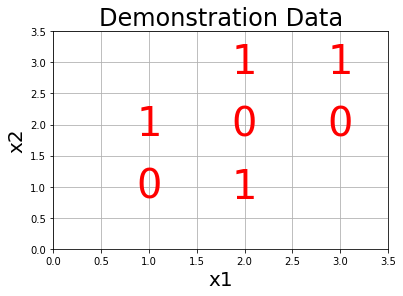

In [3]:
# nothing to do here. Just execute the command to gain a proper visualization!
%matplotlib inline

# plot each point as the label
for x1, x2, label in zip(X[:, 0], X[:, 1], y):
    plt.text(x1, x2, str(label), fontsize = 40, color = 'r',
             ha='center', va='center')
    
# plot formatting
plt.grid(None)
plt.xlim((0, 3.5))
plt.ylim((0, 3.5))
plt.xlabel('x1', size = 20); plt.ylabel('x2', size = 20); plt.title('Demonstration Data', size = 24)

A **Decision Tree Classifier (DTC)** builds a decision tree based on the features of the data. This is equivalent to subdividing the feature space. Let's consider the example above and apply a simple heuristics. In the first step we try to subdivide the space such that we obtain the _largest possible leaf (subdivision)_ that contains only **one class**.
<br><br>
We first look at the feature $x_2$, i.e. a horizontal division of the space. For example, we could divide the space at the specific threshold $x_2 = 2.5$. Then we end up having a group of samples with features $x_2 > 2.5$ and homogenous class label 1, i.e. the two points with coordinates $\{ (2,3), (3,3) \}$ . If we instead look at the feature $x_1$, corresponding to a vertical division of the space, we cannot find an equally large or larger group of samples with the same label. Therefore, our first node in the tree is: $x_2 \leq 2.5$, i.e. we split the space and repeat the same procedure on each of the two leafs. In our case we are done with the top leaf (since both samples have the same class) and only need to repeat the procedure on the bottom leaf.

Our simple heuristics from above fails on the bottom node. We need a better criterion to decide which splits to make. Nowadays the most frequently used one is called the Gini Impurity. 

The **Gini Impurity** is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.
<br>
What does that mean? Let us suppose we have $2$ labels and let $p_1, p_2$ be the fractions of points labeled with labels $1$ and $2$ (note: $p_1 + p_2 = 1$) . The probabilty to choose a point with label $1$ is $p_1$. 
The probability to choose label $2$ is $p_2 = 1-p_1$. Therefore, the probability to label a point of label $1$ with label $2$ is $p_1 \cdot p_2 = p_1 \cdot (1-p_1) = p_1 - p_1^2$. 
<br>
Analogously, the probability for points with label $2$ to be labeled with $1$ is $p_2 \cdot (1-p_2) = p_2 - p_2^2$. The Gini Impurity is the sum over both: $p_1 - p_1^2 + p_2 - p_2^2 = p_1 + p_2 - p_1^2 - p_2^2 = 1 - p_1^2 -p_2^2$
<br>
The above reasoning is easy to generalize to the case where the number of labels $M$ is larger then two: $M > 2$ . The formula for the given dataset $Z$ is simply
$I_G(Z) = 1 - \sum_{k = 1}^M p_k(Z)^2,$ where $p_k(Z)$ is the frequency of points with labels $k$ in the dataset $Z$. Your task will now be to apply these techniques explicitly to the toy data set introduced above.
<br>

The **Gini Impurity Gain** is the amount of "impurity" we get rid of for a specific split $s$.
Let's assume that we get the partition $Z_{s,1}, \ldots, Z_{s,K_s}$ of $Z$ after applying $s$. Then the impurity gain is
$g_G(Z,s) = I_G(Z) - \sum_{t=1}^{K_s} \frac{|Z_{s,t}|}{|Z|} \cdot I_G(Z_{s,t})$

**Task 1.1:**

*  Calculate the Gini impurity for our toy dataset
* Calculate the Gini impurity for the top and bottom leaf in our split (split $x_2$ at $2.5$)
* Calculate the Gini impurity gain for our split in the toy dataset 

To do this, implement the necessary calculations into the function `calc_gini` and return the 4 solutions.<br>
**Note:** Your implementation should work for any dataset similar to the toy dataset (i.e. binary labels, two dimensional)!

<h3 style="color:rgb(210,90,80)">1.1 Calculation (20 points):</h3>

In [42]:
"""
Function that calculates the Gini Impurity of the whole dataset and of the two datasets after a split is performed.
Returns also the impurity gain from this specific split.
@param X, np ndarray, data matrix
@param y, np ndarray, data vector
@param split, float, value for splitting
@param entry, int, indicating at which entry/axis/dimension the split should be performed (e.g. if entry=0 then you
would perform the split for the first feature, for entry=1 it's the second feature)
"""
def calc_gini(X,y,split,entry):    
    p = np.bincount(y) / len(y)
    pk = np.sum(p**2)
    gini_impurity = 1 - pk
    bottom_split = ([label for x, label in zip(X,y) if x[entry] <= split])
    top_split = ([label for x, label in zip(X,y) if x[entry] > split])
    
    gini_bottom = 1 - np.sum((np.bincount(bottom_split) / len(bottom_split))**2)
    gini_top = 1 - np.sum((np.bincount(top_split) / len(top_split))**2)
    impurity_gain = gini_impurity - p[0] * gini_top - p[1] * gini_bottom
    
    return gini_impurity, gini_top, gini_bottom, impurity_gain

In [43]:
gini_impurity, gini_top, gini_bottom, impurity_gain = calc_gini(X,y,2.5,1)
print("Gini impurity: {}\nGini impurity top leaf: {}\nGini impurity bottom leaf: {}\nGini impurity gain: {}".format(gini_impurity, gini_top, gini_bottom, impurity_gain))

Gini impurity: 0.48979591836734704
Gini impurity top leaf: 0.0
Gini impurity bottom leaf: 0.48
Gini impurity gain: 0.2155102040816328


<h2 style="color:rgb(0,120,170)">Task 2: Train a simple decision tree (10 points)</h2>

Next, you should provide a Python routine for the previous example. In the cells below there is the function `dec_tree` where you have to implement the following for **Task 2.1**:
* Train a decision tree on the dataset $X$ from Task 1 and remember to pass the random seed `RSEED` defined in the beginning.
* Return the number of tree nodes, the maximum depth of the tree, and the accuracy.

<h3 style="color:rgb(210,90,80)">2.1 Code (10 points):</h3>

In [44]:
"""
Trains a decision tree and returns certain attributes of the received model.
@param seed, int, seed for preserving reproducibility of random events
@param X, np ndarray, data matrix
@param y, np ndarray, data vector
"""
# Make a decision tree and train
def dec_tree(seed,X,y):
    model = DecisionTreeClassifier().fit(X,y)
    nr_nodes = model.get_n_leaves()
    max_depth = model.get_depth()
    acc = model.score(X,y)
    return nr_nodes, max_depth, acc

In [45]:
# print number of tree nodes and the maximum depth of tree
nr_nodes, max_depth, acc = dec_tree(RSEED,X,y)
print(f'Decision tree has {nr_nodes} nodes with maximum depth {max_depth}.')
print(f'Model accuracy: {acc}')

Decision tree has 6 nodes with maximum depth 4.
Model accuracy: 1.0


<h2 style="color:rgb(0,120,170)">Task 3: Decision tree on a real data set (25 points)</h2>

Now we will apply the different classifiers we have encountered so far to a real-world benchmark data set which is often used in applications, namely the "Fashion MNIST" dataset. It consists of images of clothing, like sneakers and shirts. It was created to be an alternative to the famous MNIST benchmark dataset, which is nowadays considered as too easy for the most recent algorithms. Let us first load the train and test set using the files provided in Moodle. The train and test data are represented as pixel arrays, and the label vector indicates the different classes (0 to 9).

In [46]:
# nothing to do here. Just execute the command!
data = MNIST('./dataset/')
img_train, labels_train = data.load_training()
x_train = np.array(img_train)
y_train = np.array(labels_train)

img_test, labels_test = data.load_testing()
x_test = np.array(img_test)
y_test = np.array(labels_test)

Let us plot some of the images so that you see, how these data look like.

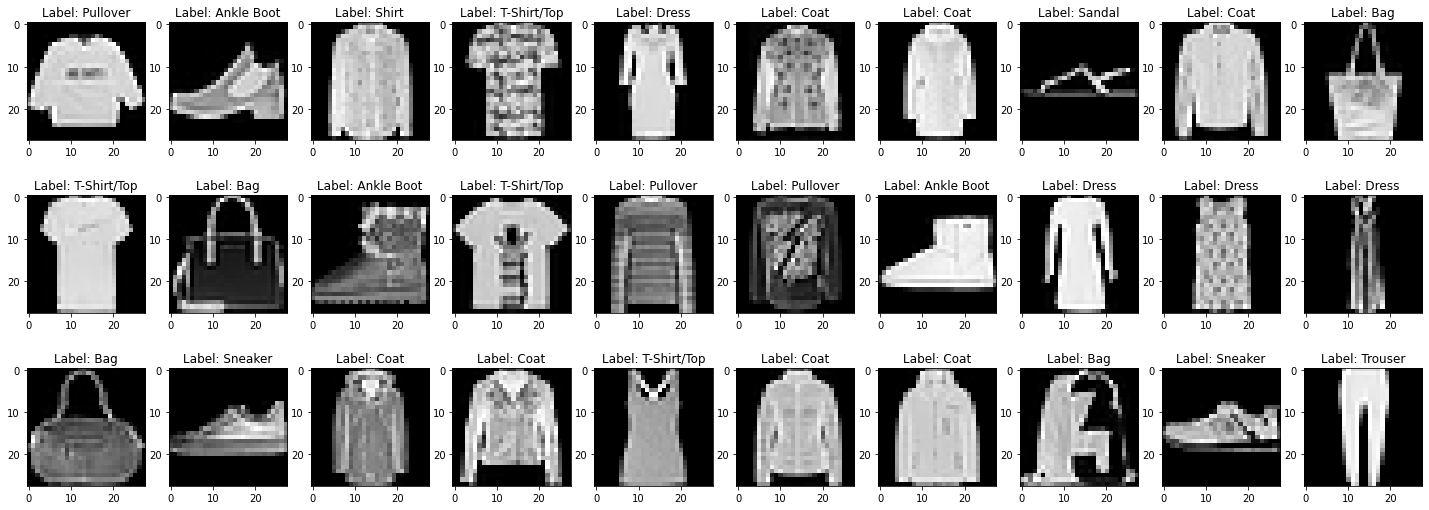

In [47]:
# nothing to do here. Just execute the command!
arr = ['T-Shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
plt.figure(figsize=(25, 9))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    two_d = (np.reshape(x_train[i], (28, 28))).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest',cmap='gray')
    plt.title('Label: {0}'.format(arr[y_train[i]]))
plt.show()

Here, we provide you with a routine that trains a decision tree for the given training set. The function `get_evaluation` should additionally help you to compute accuracies and provide confusion matrices and appropriate heatmaps.

In [48]:
# nothing to do here. Just execute the command!
print('\nPreparing classifier...')
model = DecisionTreeClassifier(criterion="gini", max_depth=50, splitter="best", random_state=RSEED)
model.fit(x_train,y_train)


Preparing classifier...


DecisionTreeClassifier(max_depth=50, random_state=50)

In [49]:
# nothing to do here. Just execute the command!
"""
Evaluates the model and returns accuracy as well as a confusion matrix. Also the time for prediction can is calculated.
@param model, sklearn model, trained model
@param x_test, np ndarray, data matrix
@param y_test, np ndarray, data vector
"""
def get_evaluation(model, x_test, y_test):
    start = time.time()
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_mat = confusion_matrix(y_test, y_pred)

    print('\nPredicted values: ', y_pred)
    print('\nAccuracy of classifier on test image data: ', accuracy)
    print('\nConfusion matrix: \n', conf_mat)
    print('\nTime: ', time.time()-start)

    plt.matshow(conf_mat)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return None


Predicted values:  [0 1 6 ... 8 8 2]

Accuracy of classifier on test image data:  0.7983

Confusion matrix: 
 [[735   5  14  43   8   3 179   1  12   0]
 [  5 965   3  16   4   0   5   0   2   0]
 [ 24   4 682  18 140   3 119   0   9   1]
 [ 43  33  17 818  48   1  36   0   4   0]
 [ 10   2 147  43 687   1 103   0   6   1]
 [  2   1   1   2   2 876   1  61  21  33]
 [172   8  99  41 107   3 553   0  16   1]
 [  1   0   0   0   0  52   2 865   5  75]
 [ 18   2  17   6  13  11  19   6 905   3]
 [  1   0   1   2   1  27   3  66   2 897]]

Time:  0.034722089767456055


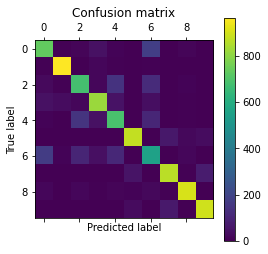

In [14]:
# nothing to do here. Just execute the command!
_ = get_evaluation(model, x_test, y_test)

In order to obtain a better performance, we apply a hyperparameter search in **Task 3.1**. 
* To this end create a parameter grid (dictionary) which iterates over the following quantities:
    - `criterion`: 'gini' and 'entropy'
    - `max_depth`: 10, 50 and 100
    - `splitter`: 'random' and 'best'
    - **Hint:** Have a look at the documentation of sklearn.model_selection.RandomizedSearchCV to get an idea of how this parameter grid should look like.
* Use a decision tree classifier and RandomizedSearchCV with 5 iterations and 3 fold cross validation. Use the built-in routines from sklearn for this and don't forget to pass `random_state=RSEED`.
* Evaluate the best parameter combination from this model.
* Print the accuracy and plot the confusion matrices and heatmaps of the model evaluated at the test set (use the previously implemented routine `get_evaluation` for this).

Again, don't forget to pass the seed in the **decision tree classifier** and **RandomizedSearchCV**. Warning: this may take several minutes ;)

<h3 style="color:rgb(210,90,80)">3.1 Code (25 points):</h3>

In [50]:
# your solution
param_dict_grid = {"criterion": ["gini", "entropy"],
                   "max_depth": [10, 50, 100],
                   "splitter": ["random", "best"]}
"""
Trains a decision tree using cross-validation and returns certain attributes of the received model including the best
parameter combination.
@param x_train, np ndarray, data matrix
@param y_train, np ndarray, data vector
@param param_grid, dict, grid holding the paramaters for search
@param seed, int , seed for preserving reducibility of random events
@param n_iter, int, number of iterations (RandomizedSearchCV)
@param cv, in, number of folds (RandomizedSearchCV)
"""
def train_dec_tree(x_train,y_train,param_dict_grid,seed,n_iter,cv):
    classifier = DecisionTreeClassifier()
    model = RandomizedSearchCV(classifier, param_dict_grid, cv = 3, n_iter = 5, n_jobs=-1, random_state=seed)
    model = model.fit(x_train, y_train)
    return model.best_params_,model


Predicted values:  [0 1 2 ... 8 2 1]

Accuracy of classifier on test image data:  0.8097

Confusion matrix: 
 [[749   5  22  35   7   3 165   2  12   0]
 [  5 963   6  16   4   2   2   0   2   0]
 [ 24   4 686  15 147   0 115   0   9   0]
 [ 37  28  17 833  42   0  39   0   3   1]
 [  8   1 156  55 685   1  89   0   5   0]
 [  3   1   0   2   1 891   3  58  11  30]
 [160   6 110  44  94   1 571   0  13   1]
 [  0   0   0   0   0  55   0 882   3  60]
 [  6   2  12   6   8  14  18   7 924   3]
 [  0   1   0   0   0  28   0  55   3 913]]

Time:  0.0328977108001709
The best parameters are: {'splitter': 'best', 'max_depth': 50, 'criterion': 'entropy'}


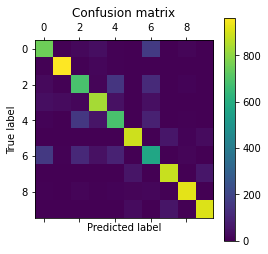

In [51]:
params_dec_tree, model_dec_tree = train_dec_tree(x_train,y_train,param_dict_grid,RSEED,5,3)
_ = get_evaluation(model_dec_tree, x_test, y_test)
print("The best parameters are: {}".format(params_dec_tree))

If you did the task correctly, you should obtain a slightly better result than before.

<h2 style="color:rgb(0,120,170)">Task 4: Comparison with KNN and SVMs (30 points)</h2>

In this task we make a comparison to the other previously used classifiers, i.e. KNNs and SVMs. Similarly as for the tree, on the Fashion MNIST dataset:

* **Task 4.1**: Implement a KNN classifier with `n_neighbors=5`, `weights='distance'`, and `p=1`. Print the accuracy and plot the confusion matrices and heatmaps of the model evaluated at the test set (again, you can use the previously implemented function `get_evaluation` for this). 
* **Task 4.2**: Implement a SVM classifier with `C=10`, `kernel='poly'`, and `gamma='auto'`. Print the accuracy and plot the confusion matrices and heatmaps of the model evaluated at the test set (again, you can use the previously implemented function `get_evaluation` for this). 

This may also take some time!

Afterwards, answer some questions that correspond to your observations (**Task 4.3**).

<h3 style="color:rgb(210,90,80)">4.1 Code (10 points):</h3>

In [19]:
"""
Trains a KNN classifier on the given dataset.
@param x_train, np ndarray, data matrix
@param y_train, np ndarray, data vector
@param n_neighbors, int, number of neighbors
@param weights, str, mode for weights
@param p, float, power parameter for the Minkowski metric (see documentation: neighbors.KNeighborsClassifier)
"""
def trainKNN(x_train,y_train,n_neighbors,weights,p):
    classifier_knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    model = classifier_knn.fit(x_train, y_train)
    return model


Predicted values:  [0 1 2 ... 8 8 2]

Accuracy of classifier on test image data:  0.8671

Confusion matrix: 
 [[875   1  13  12   3   0  88   2   6   0]
 [  5 970   8  14   1   0   2   0   0   0]
 [ 12   1 804  11  84   0  87   0   1   0]
 [ 35   9   8 888  35   0  23   0   2   0]
 [  3   0 107  27 784   0  78   0   1   0]
 [  0   0   0   1   0 881   0  70   1  47]
 [198   2 111  19  68   0 596   0   6   0]
 [  0   0   0   0   0   6   0 949   0  45]
 [  4   1  11   0   4   2   8  10 958   2]
 [  0   0   0   0   0   3   0  31   0 966]]

Time:  581.7104384899139


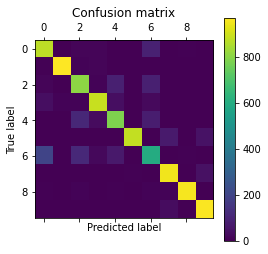

In [20]:
knn_model = trainKNN(x_train,y_train,5,'distance',1)
_ = get_evaluation(knn_model, x_test, y_test)

<h3 style="color:rgb(210,90,80)">4.2 Code (10 points):</h3>

In [21]:
"""
Trains an SVM classifier on the given dataset.
@param x_train, np ndarray, data matrix
@param y_train, np ndarray, data vector
@param kernel, str, type of kernel being used
@param gamma, float, kernel coefficient
"""
def trainSVM(x_train,y_train,C,kernel,gamma,seed):
    model = svm.SVC(C=C, kernel=kernel, gamma=gamma)
    model.fit(x_train, y_train)
    return model


Predicted values:  [0 1 2 ... 8 8 1]

Accuracy of classifier on test image data:  0.8772

Confusion matrix: 
 [[827   0  19  18   2   1 121   0  10   2]
 [  1 988   0   8   1   0   2   0   0   0]
 [ 23   2 816  13  76   1  65   0   4   0]
 [ 44  19  21 870  23   0  23   0   0   0]
 [  7   3 100  35 794   0  58   0   3   0]
 [  2   0   0   1   0 946   0  31   3  17]
 [140   6  87  34  57   0 667   0   9   0]
 [  0   0   0   0   0  16   0 942   0  42]
 [ 13   0   3   2   2   2  13   1 963   1]
 [  0   0   0   0   0  13   0  27   1 959]]

Time:  64.13495564460754


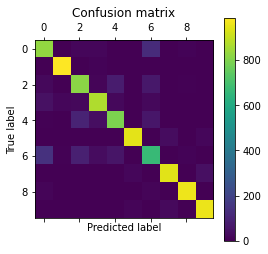

In [22]:
svm_model = trainSVM(x_train,y_train,10,'poly','auto',RSEED)
_ = get_evaluation(svm_model, x_test, y_test)

<h3 style="color:rgb(210,90,80)">4.3 Code (5 points):</h3>

Congrats, you made it this far! Now let's put everything together :)

- Collect all the accuracies from the different classifiers as well as the best parameters for the decision tree (from Task 3).
- Then, in the next cell, plot the accuracy of each classifier to compare them. Make sure to only access data that you put into the cell below (with the tag "value_check").

**Note:** Please assign the numerical values to the variables in float format (i.e. 0.9876 for 98.76% accuracy).

In [29]:
# for your reference:
# Accuracy:
classifier1 = 0.9876
# Parameters:
parameter1 = 'split'

dec_tree_fixed_params_acc = 0.7983

# your solution:
dec_tree_best_params_acc = 0.8068
KNN_acc = 0.8671
SVM_acc = 0.8772

# Best parameters dec_tree:
par_splitter_ = "best"
par_maxdepth_ = 50
par_criterion_ = "entropy"

Text(0.5, 1.0, 'Classifier Comparison')

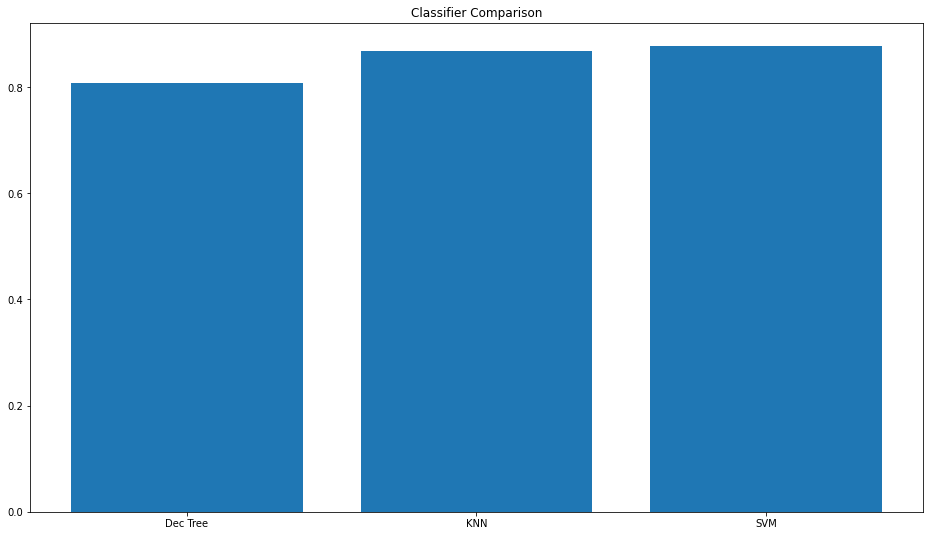

In [32]:
# your code for the visualization

# example: plt.figure...
# plt.plot...
acc = [dec_tree_best_params_acc,KNN_acc,SVM_acc]
plt.figure(figsize=(16,9))
plt.bar(["Dec Tree","KNN", "SVM"],acc)
plt.title("Classifier Comparison")

<h3 style="color:rgb(210,90,80)">4.4 Question (5 points):</h3>

***What observations can you make so far? Add your answer to the variables below (several may be correct).***

According to the `get_evaluation` function:

a_) The decision tree model is faster in terms of inference time and yields a better accuracy than KNN and SVM. <br>
b_) SVM is the algorithm with the highest accuracy among KNN, SVM, and decision trees.<br>
c_) Although this is already a large dataset, it is surprising that the SVM with kernel has higher prediction time than the decision tree.

To answer the question, assign "True" or "False" boolean values to variables in the next cell. A non-correctly answered question yields negative points and no answer (i.e. answer “None”) gives 0 points for a question. More details on grading can be found in the [FAQ sheet](https://docs.google.com/document/d/11ccAoEWh1APAoj79kGFiL64_7OL7RApPUHJ2-cvS2s0/edit?usp=sharing).<br>
<b>Note:</b> Do not reuse these variable names. They are used for testing.

In [33]:
#examples for you
example_of_true_variable = True
example_of_false_variable = False

#your answers go here
a_=False
b_=True
c_=True

<h2 style="color:rgb(0,120,170)">Task 5: Preparation towards ensembles of trees (15 points)</h2>

In the upcoming lectures, you will discuss ensemble methods for trees that aggregate and/or average single tree models to achieve better performances and/or faster runtimes compared to the ones we used here. Random Forest is a famous example where we average over trees such that the overall variance (of the average) is reduced. We will now formalize the situation:

Let's say you have $X_1,...,X_B$ identically distributed random variables which are NOT necessarily independent. Let us denote the variance of a single variable $X_i$ by $\sigma^2$ and the correlation coefficient between two $X_i$ and $X_j$ for $j \ne i$ by $\rho=\frac{E(X_i X_j)-E(X_i)E(X_j)}{\sigma^2}$ (keep in mind that all $X_i$'s are identically distributed!). 

In **Task 5.1**, show that $$\text{Var}\left(\frac{1}{B} \sum_{i=1}^B X_i \right)=\rho \sigma^2 +\frac{1-\rho}{B} \sigma^2. \quad (1)$$
This gives some intuition about how to control the overall variance of averages. One can reduce it e.g. by a small correlation coefficient $\rho$ and a large number of models $B$.

1. Apply the definition of the variance to the given average. 
2. Split up the resulting double sum in parts with equal and unequal indices. 
3. Apply the definition for $\rho$ and replace the sums with the number of occurences of the respective term (how often the indices appear).
4. Rewrite this to get the desired solution.

**Note:** Denote in your calculation where you tackle each of this points.

<h3 style="color:rgb(210,90,80)">5.1 Calculation (15 points):</h3>

\begin{align}
\ \text{Var}\left(\frac{1}{B} \sum_{i=1}^B X_i \right)& = \frac{1}{B^2} \text{Var}\left(\frac{1}{B} \sum_{i=1}^B X_i \right) \\
\ & = \frac{1}{B^2} \sum_{i=1}^B \sum_{j=1}^B \text{Cov} (X_i,X_j) \\
\ & =  \frac{1}{B^2} \sum_{i = 1}^B \left( \sum_{j \neq i}^B \text{Cov} (X_i,X_j) + \text{Var}(X_i) \right) \\
\ & = \frac{1}{B^2} \sum_{i = 1}^B \left( (B-1)\sigma^2 \rho + \sigma^2\right) \\
\ &= \frac{B(B-1)\rho\sigma^2+B\sigma^2}{B^2}\\
\ &= \frac{(B-1)\rho\sigma^2}{b} + \frac{\sigma^2}{B} \\
\ &= \rho\sigma^2 - \frac{\rho \sigma^2}{B} + \frac{\sigma^2}{B} \\
\ &= \rho\sigma^2 + \sigma^2 \frac{1-\rho}{B}
\end{align}

**Note:** The execution of this notebook will take a while, i.e., it might run for 20-30 minutes. For testing purposes, you might work with a reduced dataset (Task 4) but make sure to report the numbers etc. for the whole dataset!